In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy.optimize import fsolve

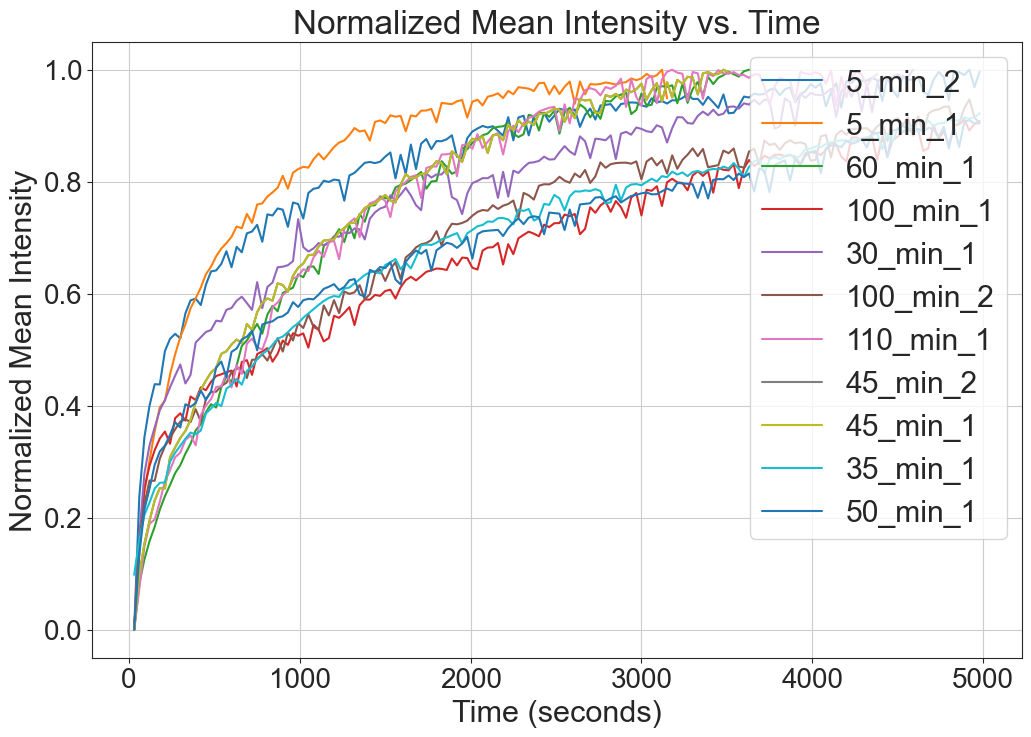

In [196]:
path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/FRAP/frap_data'  # Update this path accordingly

# Create an empty DataFrame to store concatenated results
all_data = pd.DataFrame()

# Iterate through all CSV files in the specified directory
for file in glob.glob(os.path.join(path, '*.csv')):
    # Read each file
    df = pd.read_csv(file)
    
    # Extract filename without the extension to use as a column name
    filename = os.path.basename(file).split('.')[0]
    
    # Normalize the 'Mean' column
    df['Normalized Mean'] = (df['Mean'] - df['Mean'].min()) / (df['Mean'].max() - df['Mean'].min())
    
    # Add normalized data to the all_data DataFrame, setting the 'Slice' as index
    all_data[filename] = df.set_index('Slice')['Normalized Mean']

# Ensure 'Slice' is properly set as index if not already
all_data.reset_index(inplace=True, drop=False)  # 'Slice' remains as a column but we'll handle it separately

# Calculate time in seconds
all_data['Time (sec)'] = all_data['Slice'] * 30

# Plotting each column against time
plt.figure(figsize=(12, 8))

for column in all_data.columns[1:]:  # Exclude the first column ('Slice')
    if column != 'Time (sec)':  # Ensure 'Time (sec)' is not in the columns to be plotted
        plt.plot(all_data['Time (sec)'], all_data[column], label=column)

plt.title('Normalized Mean Intensity vs. Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Mean Intensity')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()

all_data.to_csv('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/FRAP/frap_data.csv', index=False)


In [197]:
# find the closest to the midpoint
def find_closest(df, col_name):
    value = (df[col_name].max() - df[col_name].min()) / 2
    dist = (df[col_name] - value).abs()
    return dist.idxmin()

In [198]:
# Calculate tau half for mid point
tau_half = []
incubation_times = []

# Calculate time in seconds
all_data['Time (sec)'] = all_data['Slice'] * 30

# Iterate over each column except 'Slice' and 'Time (sec)'
for column in all_data.columns[1:-1]:
    idx_min = find_closest(all_data, column)
    tau_half.append(all_data.loc[idx_min, 'Time (sec)'])
    
    # Extract incubation time from file name (assuming format a_min_b)
    parts = column.split('_')
    incubation_time = parts[0]
    incubation_times.append(incubation_time)

# Save tau_half and incubation times
tau_half_data = pd.DataFrame({
    'Incubation Time (min)': incubation_times,
    'Tau Half (sec)': tau_half
})

In [199]:
tau_half_data

,Incubation Time (min),Tau Half (sec)
0,5,210
1,5,270
2,60,660
3,100,720
4,30,390
5,100,660
6,110,780
7,45,570
8,45,570
9,35,510


Equation from Daniel Axelrod paper. EQ 19

$$
  D = (w^2 /\, 4\tau_{1/2})\, \gamma_D
$$

Where
$$ \gamma_D = 0.88 $$
for circular beams, and
$$ w $$
is radius of the uniform laser beam

The optical setup we used has a resolution of 0.294 um/pixel

In [200]:
# Constants and initial values
res = 0.294
r_circle = 120
w = res * r_circle
D = []

# Compute D for each value in tau_half
for num in tau_half:
    D_value = 0.88 * (w ** 2) / (4 * num)
    D.append(D_value)

# Create a DataFrame to store and display results
results_df = pd.DataFrame({
    'Incubation Time (min)': incubation_times,
    'Tau Half (sec)': tau_half,
    'Diffusion Coefficient (D)': D
})

# Display results
print(results_df)

   Incubation Time (min)  Tau Half (sec)  Diffusion Coefficient (D)
0                      5             210                   1.303949
1                      5             270                   1.014182
2                     60             660                   0.414893
3                    100             720                   0.380318
4                     30             390                   0.702126
5                    100             660                   0.414893
6                    110             780                   0.351063
7                     45             570                   0.480402
8                     45             570                   0.480402
9                     35             510                   0.536920
10                    50             570                   0.480402


In [201]:


# Constants
k_B = 1.38e-23  # Boltzmann constant in J/K
T = 25 + 273.15  # Temperature in Kelvin
eta = 2e-3  # Viscosity in Pa.s
r = 12.5e-9  # Radius in meters

def equation(log_length, diffusion_coeff):
    length = np.exp(log_length)
    return (2 * np.pi * eta * length * diffusion_coeff) / (k_B * T) - log_length + np.log(2 * r) + 0.2

def calculate_length(diffusion_coeff):
    # Convert diffusion coefficient from um^2/s to m^2/s
    diffusion_coeff *= 1e-12

    initial_guess = -12  # initial guess for log(length), corresponds to length ~ 1e-6 m
    log_length_solution = fsolve(equation, initial_guess, args=(diffusion_coeff,))

    if log_length_solution.size > 0:
        length_m = np.exp(log_length_solution[0])  # length in meters
        length_um = length_m * 1e6  # Convert the length from meters to micrometers
        return length_um
    else:
        return None

# Assume 'results_df' is your DataFrame from previous steps
lengths = []

# Iterate over each row in the DataFrame
for index, row in results_df.iterrows():
    length_um = calculate_length(row['Diffusion Coefficient (D)'])
    lengths.append(length_um)

# Add the calculated lengths to the DataFrame
results_df['Calculated Length (um)'] = lengths

# Display the updated DataFrame
print(results_df)


   Incubation Time (min)  Tau Half (sec)  Diffusion Coefficient (D)  \
0                      5             210                   1.303949   
1                      5             270                   1.014182   
2                     60             660                   0.414893   
3                    100             720                   0.380318   
4                     30             390                   0.702126   
5                    100             660                   0.414893   
6                    110             780                   0.351063   
7                     45             570                   0.480402   
8                     45             570                   0.480402   
9                     35             510                   0.536920   
10                    50             570                   0.480402   

    Calculated Length (um)  
0                 0.828945  
1                 1.179706  
2                 3.808631  
3                 4.249082  
4 

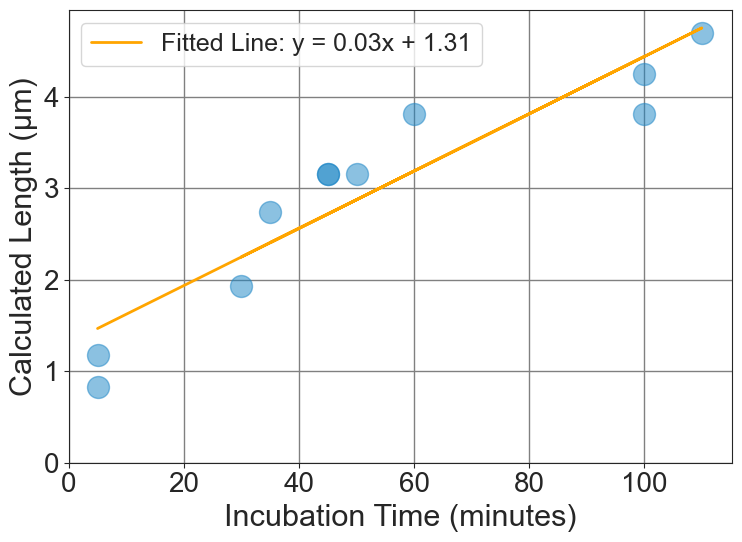

In [206]:
# Verify data types and convert if necessary
results_df['Incubation Time (min)'] = pd.to_numeric(results_df['Incubation Time (min)'], errors='coerce')
results_df['Calculated Length (um)'] = pd.to_numeric(results_df['Calculated Length (um)'], errors='coerce')

# Drop any rows with NaN values (if any)
results_df = results_df.dropna(subset=['Incubation Time (min)', 'Calculated Length (um)'])

# Convert to numpy arrays
t = np.array(results_df['Incubation Time (min)'])
length = np.array(results_df['Calculated Length (um)'])

# Perform linear regression to find slope (m) and intercept (b)
slope, intercept = np.polyfit(t, length, 1)

# Generate fitted line values
fitted_line = slope * t + intercept

# Set the style of seaborn for prettier plots
sns.set_style('ticks')

# Set larger font sizes
plt.rc('font', size=26)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=18)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot original data points
ax.scatter(t, length, color='#1984c5', alpha=0.5, s=250)

# Plot the fitted line
ax.plot(t, fitted_line, '-', color='orange', label=f'Fitted Line: y = {slope:.2f}x + {intercept:.2f}', linewidth=2)

# Titles and labels
ax.set_xlabel("Incubation Time (minutes)")
ax.set_ylabel("Calculated Length (μm)")

# Set x and y axis limits
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Add grid
ax.grid(True, linestyle='-', linewidth=1, color='grey')

# Show legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
